Liz Rightmire

November, 2024

# N1 Health Data Challenge

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from shapely.wkt import loads


### Data

In [15]:
places = pd.read_csv("Datasets/500cities/CDC_Places.csv")
access = pd.read_csv("Datasets/FoodEnvironmentAtlas/access.csv")
stores = pd.read_csv("Datasets/FoodEnvironmentAtlas/stores.csv")
socioeconomic = pd.read_csv("Datasets/FoodEnvironmentAtlas/socioeconomic.csv")

# create column with grocery stores, super stores, and specialized food stores per 1,000 people. 
# convenience stores, restauraunts not of interest.
stores['Food Stores per 1,000 people'] = stores['GROCPTH16'] + stores['SUPERCPTH16'] + stores['SPECSPTH16']

/var/folders/nd/3yjvm85j3rq1vhh53yn6cy0r0000gn/T/ipykernel_48016/1314167469.py:1: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  places = pd.read_csv("Datasets/500cities/CDC_Places.csv")


In [16]:
# Merge health datasets

# age-adjusted diabetes measures for each county
diabetes = places[(places['MeasureId'] == 'DIABETES') & (places['Data_Value_Type'] == 'Age-adjusted prevalence')] 
diabetes_filtered = diabetes[['StateDesc', 'LocationName', 'LocationID', 'Data_Value', 'Geolocation']]
diabetes_filtered.rename(columns = {'Data_Value' : 'Diabetes Rate (%)'}, inplace=True)
diabetes_filtered = diabetes_filtered.dropna(subset=['Geolocation']) # drop NA Geolocations

# age-adjusted obesity measures for each county
obesity = places[(places['MeasureId'] == 'OBESITY') & (places['Data_Value_Type'] == 'Age-adjusted prevalence')]
obesity_filtered = obesity[['LocationID', 'Data_Value']]
obesity_filtered.rename(columns = {'Data_Value' : 'Obesity Rate (%)'}, inplace=True)

# merge
health_merged = pd.merge(diabetes_filtered,
                         obesity_filtered,
                         how = "inner",
                         on = "LocationID"
                         )

# clean
health_merged.rename(columns = {'LocationID' : 'FIPS', 
                                'StateDesc' : 'State',
                                'LocationName' : 'County'
                                }, inplace=True)

# Convert Geolocation to geometry if stored as WKT strings
health_merged['geometry'] = health_merged['Geolocation'].apply(loads)

health_merged.head()

/var/folders/nd/3yjvm85j3rq1vhh53yn6cy0r0000gn/T/ipykernel_48016/2894101497.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diabetes_filtered.rename(columns = {'Data_Value' : 'Diabetes Rate (%)'}, inplace=True)
/var/folders/nd/3yjvm85j3rq1vhh53yn6cy0r0000gn/T/ipykernel_48016/2894101497.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obesity_filtered.rename(columns = {'Data_Value' : 'Obesity Rate (%)'}, inplace=True)


,State,County,FIPS,Diabetes Rate (%),Geolocation,Obesity Rate (%),geometry
0,Alaska,Skagway,2230,8.0,POINT (-135.336028290736 59.5592737178809),33.0,POINT (-135.336028290736 59.5592737178809)
1,Alaska,Yukon-Koyukuk,2290,13.4,POINT (-151.390098989755 65.5085661031514),39.5,POINT (-151.390098989755 65.5085661031514)
2,Arkansas,Clark,5019,14.3,POINT (-93.1767308539705 34.0510757211807),40.4,POINT (-93.1767308539705 34.0510757211807)
3,California,Alpine,6003,8.8,POINT (-119.820667930537 38.5974751291386),29.9,POINT (-119.820667930537 38.5974751291386)
4,Alabama,Pike,1109,13.7,POINT (-85.9407627085231 31.8027535253528),40.6,POINT (-85.9407627085231 31.8027535253528)


In [17]:
# Food Atlas Merge

# merge
atlas_merged = pd.merge(access[["FIPS", "LACCESS_LOWI15", "LACCESS_HHNV15", "LACCESS_SENIORS15", "PCH_LACCESS_SENIORS_10_15"]], 
                        stores[["FIPS", "Food Stores per 1,000 people"]],
                       on= "FIPS", 
                       how="inner")

# clean
atlas_merged = atlas_merged.rename(columns={'LACCESS_LOWI15': 'Population, Low income & low access to store (count, 2015)',
                                            'LACCESS_HHNV15' : 'Households with no car & low access to store, (count, 2015)',
                                            'LACCESS_SENIORS15' : "Seniors, low access to store (count, 2015)",
                                            'PCH_LACCESS_SENIORS_10_15' : 'Seniors, low access to store (% change, 2010-15)'
                                            })

atlas_merged.head()

,FIPS,"Population, Low income & low access to store (count, 2015)","Households with no car & low access to store, (count, 2015)","Seniors, low access to store (count, 2015)","Seniors, low access to store (% change, 2010-15)","Food Stores per 1,000 people"
0,1001,6543.676824,677.672769,2180.809285,-8.685247,0.090452
1,1003,9886.831137,1394.162766,5580.662790,-12.856726,0.303601
2,1005,2948.790251,425.144927,824.175262,7.005933,0.271592
3,1007,596.162829,224.388125,137.688231,-8.545207,0.265100
4,1009,1650.959482,719.931444,505.914282,159.377977,0.104235


In [18]:
# final merge
all_data = pd.merge(health_merged, 
                    atlas_merged,
                    on= "FIPS", 
                    how="inner")

all_data.head()

,State,County,FIPS,Diabetes Rate (%),Geolocation,Obesity Rate (%),geometry,"Population, Low income & low access to store (count, 2015)","Households with no car & low access to store, (count, 2015)","Seniors, low access to store (count, 2015)","Seniors, low access to store (% change, 2010-15)","Food Stores per 1,000 people"
0,Alaska,Skagway,2230,8.0,POINT (-135.336028290736 59.5592737178809),33.0,POINT (-135.336028290736 59.5592737178809),0.488926,2.503659,0.700644,0.000000,0.000000
1,Alaska,Yukon-Koyukuk,2290,13.4,POINT (-151.390098989755 65.5085661031514),39.5,POINT (-151.390098989755 65.5085661031514),2779.799148,1116.944260,568.999999,0.000000,1.662971
2,Arkansas,Clark,5019,14.3,POINT (-93.1767308539705 34.0510757211807),40.4,POINT (-93.1767308539705 34.0510757211807),4933.730696,314.650723,1154.316068,191.230248,0.133038
3,California,Alpine,6003,8.8,POINT (-119.820667930537 38.5974751291386),29.9,POINT (-119.820667930537 38.5974751291386),146.579098,9.321428,89.075946,-12.338559,0.000000
4,Alabama,Pike,1109,13.7,POINT (-85.9407627085231 31.8027535253528),40.6,POINT (-85.9407627085231 31.8027535253528),2074.066321,563.044138,497.671826,14.936697,0.240855


### Priority List

In [82]:
# sort by seniors with low access to store
top_20_insecurity = all_data.sort_values(by='Seniors, low access to store (count, 2015)', ascending=False).head(20)

# specify column order
column_order = ['County',
                'State',
                'Seniors, low access to store (count, 2015)',
                'Seniors, low access to store (% change, 2010-15)',
                'Population, Low income & low access to store (count, 2015)',
                'Food Stores per 1,000 people',
                'Obesity Rate (%)',
                'Diabetes Rate (%)']

# list of specific columns to round
round_zero = ['Seniors, low access to store (count, 2015)', 
            'Population, Low income & low access to store (count, 2015)']

round_two = ['Seniors, low access to store (% change, 2010-15)', 
            'Food Stores per 1,000 people',]

# round 
top_20_insecurity[round_zero] = top_20_insecurity[round_zero].round(0).astype(int)
top_20_insecurity[round_two] = top_20_insecurity[round_two].round(2)

# display top 20 counties
top_20_insecurity = top_20_insecurity[column_order]
prioritylist = top_20_insecurity.to_excel('maricopa_output.xlsx', index=False)


### Food Atlas with Coordinates

In [20]:
# Convert df to GeoDataFrame
gdf = gpd.GeoDataFrame(all_data, geometry='geometry')

# Ensure the Coordinate Reference System (CRS) is set. Use EPSG:4326 for lat/lon
gdf.set_crs("EPSG:4326", inplace=True)

# load USA states basemap
states = gpd.read_file("states/states.shp")

# match CRS
states = states.to_crs(gdf.crs)

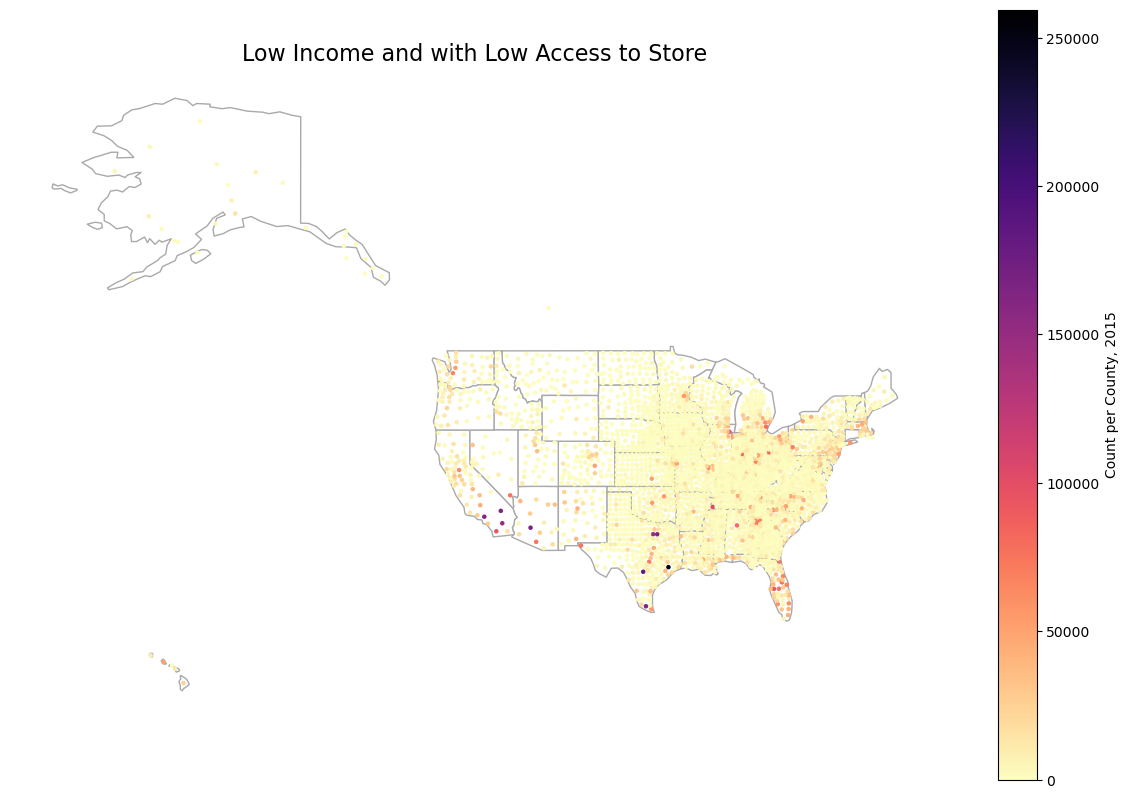

In [21]:
# Plot the USA map and overlay the population data
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot USA boundaries
states.plot(ax=ax, color='white', edgecolor='darkgrey')

# Overlay the cities data
gdf.plot(column='Population, Low income & low access to store (count, 2015)', 
         cmap='magma_r', 
         legend=True, 
         legend_kwds={'label': 'Count per County, 2015', 'orientation': 'vertical'},
         ax=ax, 
         markersize=5)

# Customize the plot
ax.set_title("Low Income and with Low Access to Store", fontsize=16)
plt.axis("off")
plt.show()

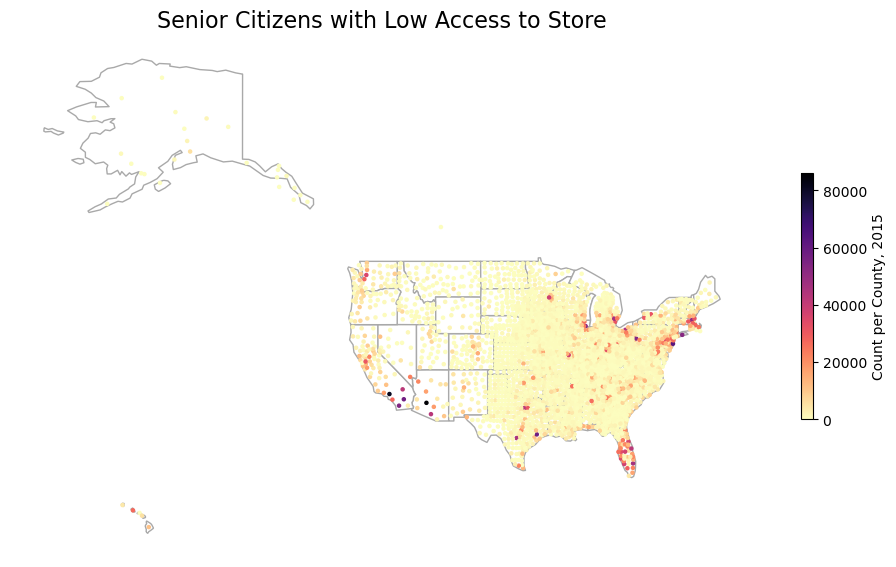

In [78]:
# Plot the USA map and overlay the population data
from matplotlib.ticker import FuncFormatter


fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot USA boundaries
states.plot(ax=ax, color='white', edgecolor='darkgrey')

# Overlay the cities data
gdf.plot(column='Seniors, low access to store (count, 2015)', 
         cmap='magma_r', 
         legend=True, 
         legend_kwds={'label': 'Count per County, 2015', 
                      'orientation': 'vertical',
                      'shrink' : 0.4,
                      'location' : 'right'},
         ax=ax, 
         markersize=5)

ax.set_title("Senior Citizens with Low Access to Store", fontsize=16)
plt.axis("off")
plt.show()

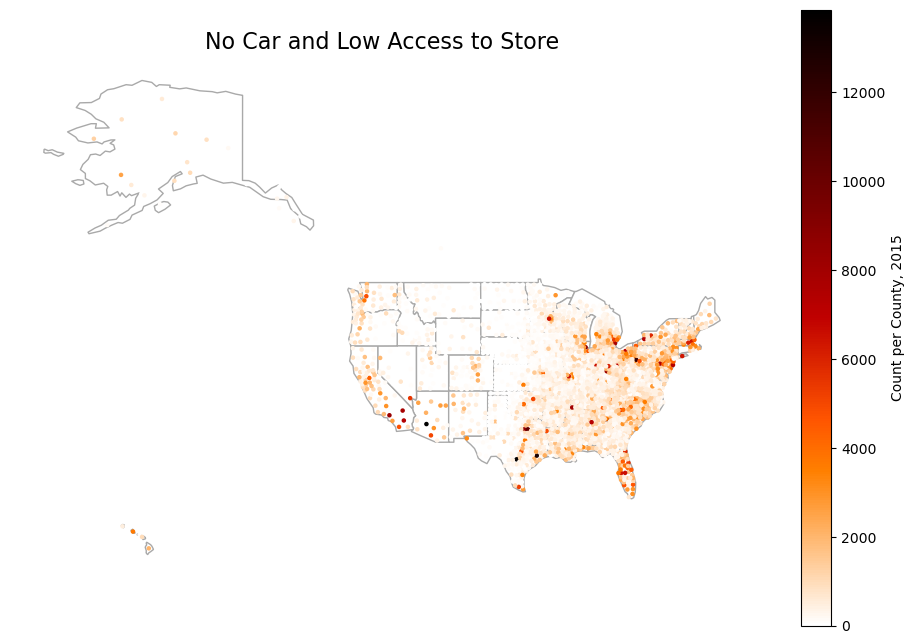

In [75]:
# Plot the USA map and overlay the population data
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot USA boundaries
states.plot(ax=ax, color='white', edgecolor='darkgrey')

# Overlay the cities data
gdf.plot(column='Households with no car & low access to store, (count, 2015)', 
         cmap='gist_heat_r', 
         legend=True, 
         legend_kwds={'label': 'Count per County, 2015', 'orientation': 'vertical'},
         ax=ax, 
         markersize=5)

# Customize the plot
ax.set_title("No Car and Low Access to Store", fontsize=16)
plt.axis("off")
plt.show()

### Demographics Charts

In [24]:
socioeconomic.rename(columns = {'PCT_NHWHITE10' : 'White',
                                'PCT_NHBLACK10' : 'Black',
                                'PCT_HISP10' : 'Hispanic', 
                                'PCT_NHASIAN10' : 'Asian', 
                                'PCT_NHNA10' : 'American Indian or Alaska Native',
                                'PCT_NHPI10' : 'Hawaiian or Pacific Islander',
                                'PCT_65OLDER10' : '65 years or older',
                                'PCT_18YOUNGER10' : 'Under Age 18'}, inplace=True)

socioeconomic['Age 18 -- 65'] = 100 - (socioeconomic['65 years or older'] + socioeconomic['Under Age 18'])

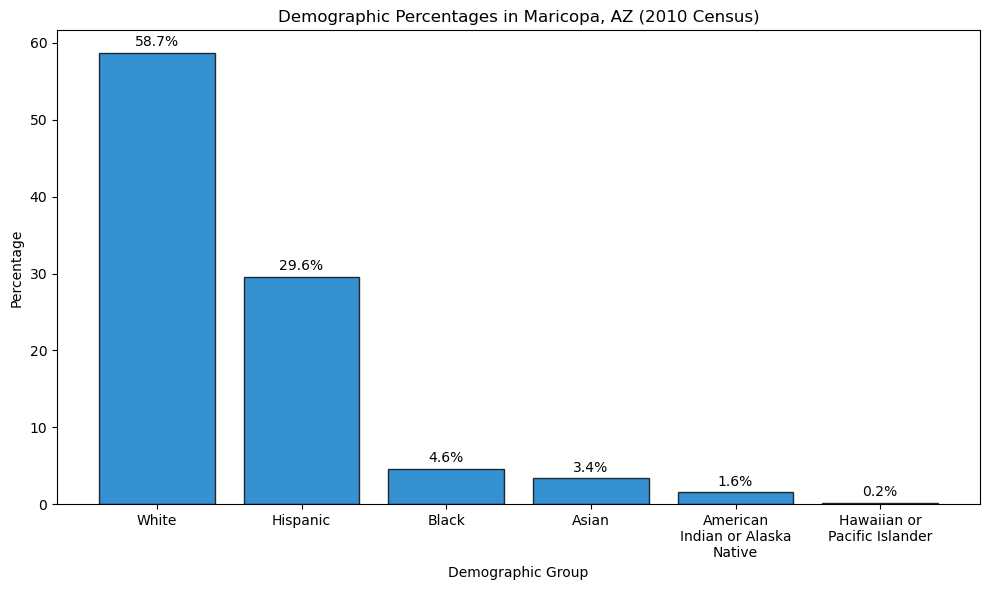

In [39]:
maricopa = socioeconomic[socioeconomic['FIPS'] == 4013]

# Select columns for the bar plot
columns_to_plot = ['White', 'Black', 'Hispanic', 'Asian', 
                   'American Indian or Alaska Native', 'Hawaiian or Pacific Islander']
values = maricopa[columns_to_plot].iloc[0]  # Extract the first row of values

# Sort the values in descending order
values = values.sort_values(ascending=False)

# Modify labels to include line breaks for longer labels
labels = [
    'White', 
    'Black', 
    'Hispanic', 
    'Asian', 
    'American\nIndian or Alaska\nNative', 
    'Hawaiian or\nPacific Islander'
]

# Ensure labels align with sorted values
sorted_labels = [labels[columns_to_plot.index(col)] for col in values.index]

# Create the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(sorted_labels, values.values, color='#0476c9', edgecolor='black', alpha=0.8)
#plt.bar(sorted_labels, values.values, color='skyblue', edgecolor='black', alpha=0.8)

# Add labels and title
plt.title('Demographic Percentages in Maricopa, AZ (2010 Census)')
plt.xlabel('Demographic Group')
plt.ylabel('Percentage')
plt.xticks(ha='center', size = 10) 

# Add percentages on top of each bar
for bar in bars:
    yval = bar.get_height()  # Get the height of the bar (the percentage value)
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5,  # Positioning above the bar
             f'{yval:.1f}%', ha='center', va='bottom', fontsize=10)  # Display the percentage

# Show the plot
plt.tight_layout()  # Adjust layout to prevent label overlap
plt.show()


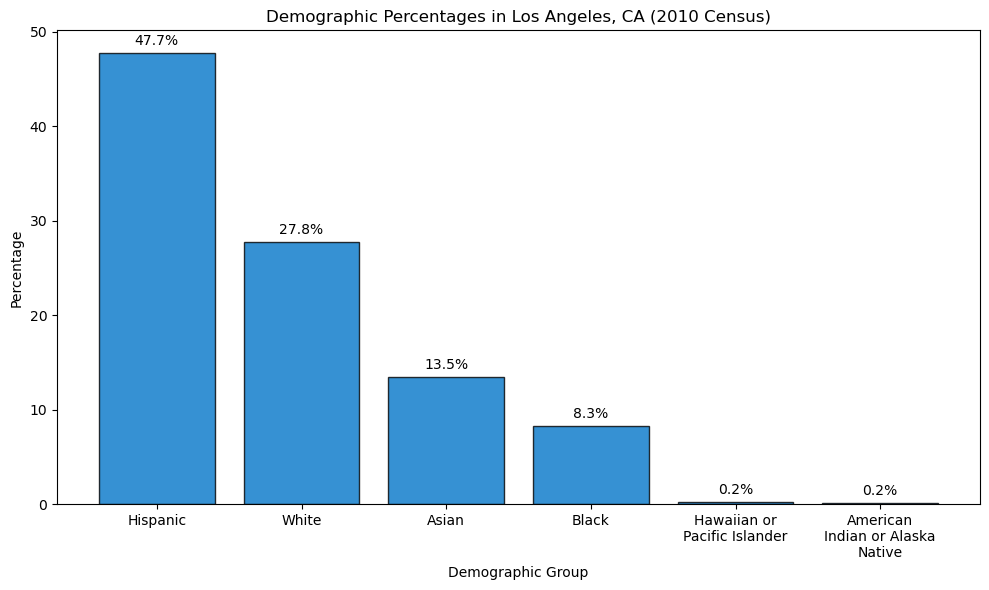

In [38]:
LA = socioeconomic[socioeconomic['FIPS'] == 6037]

# Select columns for the bar plot
columns_to_plot = ['White', 'Black', 'Hispanic', 'Asian', 
                   'American Indian or Alaska Native', 'Hawaiian or Pacific Islander']

values = LA[columns_to_plot].iloc[0]  # Extract the first row of values

# Sort the values in descending order
values = values.sort_values(ascending=False)

# Modify labels to include line breaks for longer labels
labels = [
    'White', 
    'Black', 
    'Hispanic', 
    'Asian', 
    'American\nIndian or Alaska\nNative', 
    'Hawaiian or\nPacific Islander'
]

# Ensure labels align with sorted values
sorted_labels = [labels[columns_to_plot.index(col)] for col in values.index]

# Create the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(sorted_labels, values.values, color='#0476c9', edgecolor='black', alpha=0.8)
#plt.bar(sorted_labels, values.values, color='skyblue', edgecolor='black', alpha=0.8)

# Add labels and title
plt.title('Demographic Percentages in Los Angeles, CA (2010 Census)')
plt.xlabel('Demographic Group')
plt.ylabel('Percentage')
plt.xticks(ha='center', size = 10) 

# Add percentages on top of each bar
for bar in bars:
    yval = bar.get_height()  # Get the height of the bar (the percentage value)
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5,  # Positioning above the bar
             f'{yval:.1f}%', ha='center', va='bottom', fontsize=10)  # Display the percentage

# Show the plot
plt.tight_layout()  # Adjust layout to prevent label overlap
plt.show()

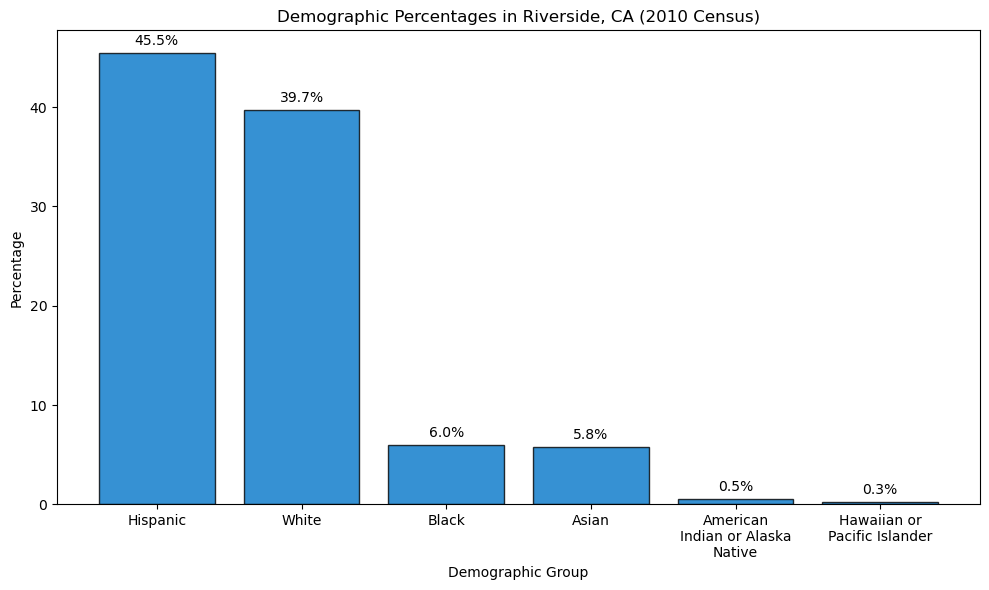

In [34]:
Riverside = socioeconomic[socioeconomic['FIPS'] == 6065]

# Select columns for the bar plot
columns_to_plot = ['White', 'Black', 'Hispanic', 'Asian', 
                   'American Indian or Alaska Native', 'Hawaiian or Pacific Islander']

values = Riverside[columns_to_plot].iloc[0]  # Extract the first row of values

# Sort the values in descending order
values = values.sort_values(ascending=False)

# Modify labels to include line breaks for longer labels
labels = [
    'White', 
    'Black', 
    'Hispanic', 
    'Asian', 
    'American\nIndian or Alaska\nNative', 
    'Hawaiian or\nPacific Islander'
]

# Ensure labels align with sorted values
sorted_labels = [labels[columns_to_plot.index(col)] for col in values.index]

# Create the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(sorted_labels, values.values, color='#0476c9', edgecolor='black', alpha=0.8)
#plt.bar(sorted_labels, values.values, color='0476c9', edgecolor='dargrey', alpha=0.8)

# Add labels and title
plt.title('Demographic Percentages in Riverside, CA (2010 Census)')
plt.xlabel('Demographic Group')
plt.ylabel('Percentage')
plt.xticks(ha='center', size = 10) 

# Add percentages on top of each bar
for bar in bars:
    yval = bar.get_height()  # Get the height of the bar (the percentage value)
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5,  # Positioning above the bar
             f'{yval:.1f}%', ha='center', va='bottom', fontsize=10)  # Display the percentage

# Show the plot
plt.tight_layout()  # Adjust layout to prevent label overlap
plt.show()

### Appendix: Health Map

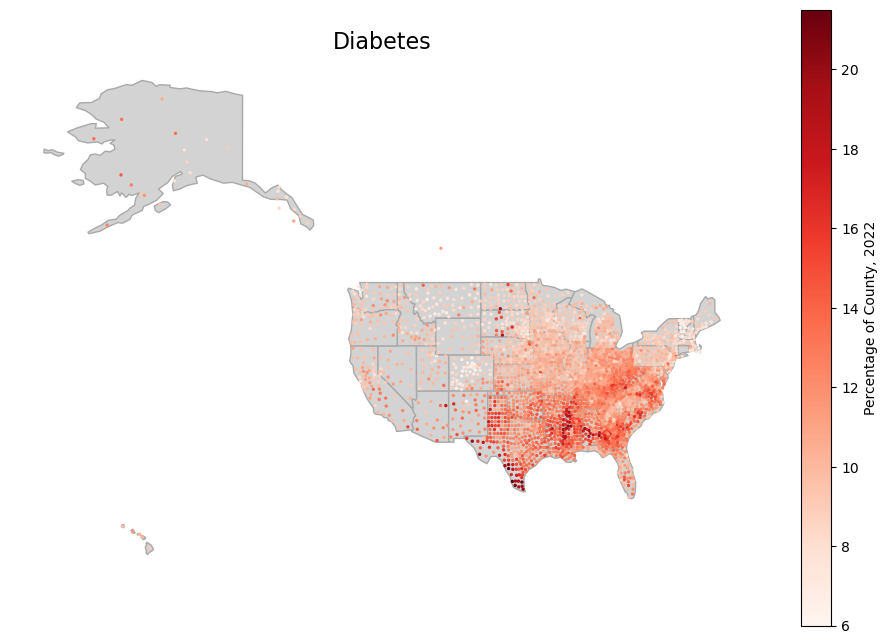

In [29]:
# plot basemap
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
states.plot(ax=ax, color='lightgray', edgecolor='darkgrey')

# overlay points
gdf.plot(
    column='Diabetes Rate (%)',
    cmap='Reds',
    legend=True,
    markersize=2,
    legend_kwds={'label': 'Percentage of County, 2022', 'orientation': 'vertical'},
    ax=ax
)

# styling
ax.set_title("Diabetes", fontsize=16)
ax.axis('off')
plt.show()

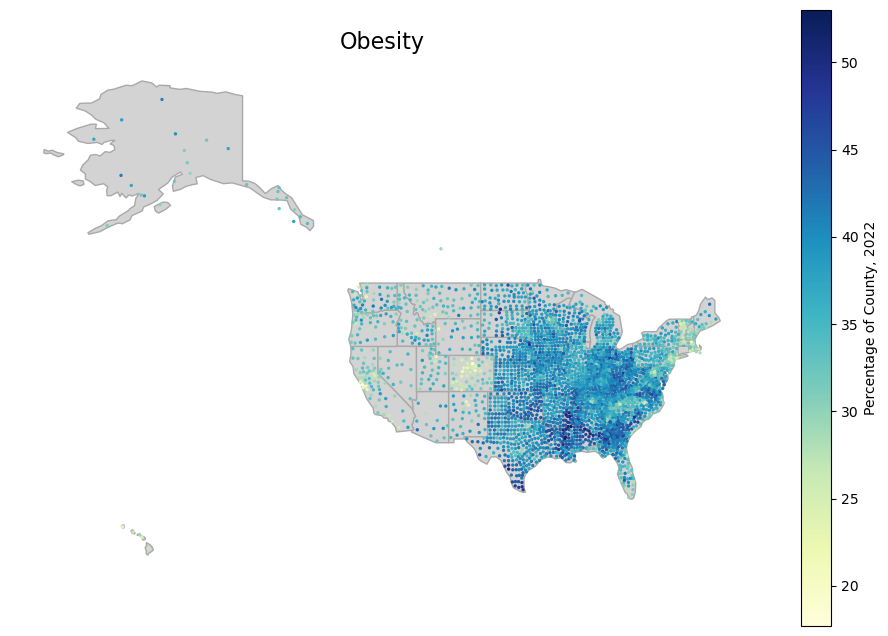

In [30]:
# plot basemap
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
states.plot(ax=ax, color='lightgray', edgecolor='darkgrey')

# overlay points
gdf.plot(
    column='Obesity Rate (%)',
    cmap='YlGnBu',
    legend=True,
    markersize=2,
    legend_kwds={'label': 'Percentage of County, 2022', 'orientation': 'vertical'},
    ax=ax
)

# styling
ax.set_title("Obesity", fontsize=16)
ax.axis('off')
plt.show()